# Flattening and glacier gridpoint selection tests:

- the tests take too long inside of the OGGM framework and would need all the flattened datasets. Therefore it is done here:
    - We check if the climate is the same of the flattened and unflattened files,
        - we also check if GSWP3-W5E5 is equal to the flattened W5E5v2.0 in the common time period!
    - did we always select the nearest glacier gridpoints? (this was wrong for around 11900 glaciers in v2022.2, but now work in v2023.2 upwards)
- created test GSWP3-W5E5, ERA5 and ISIMIP3b files for pytest

**Currently updated to check if RGI6, RGI7C and RGI7G glacier gridpoints are correctly included**

In [14]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time
from oggm import utils
import sys
import pandas as pd
import os

**Let's get all glacier longitude / latitude to check later the distance to the nearest gridpoints:**

In [38]:
# get the dataset where coordinates of glaciers are stored
frgi_6 = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
odf_6 = pd.read_hdf(frgi_6, index_col=0)
odf_6['coords'] = [(lon,lat) for lon,lat in zip(odf_6['CenLon'],odf_6['CenLat'])]

#### glacier complexes
frgi_7C = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/RGI2000-v7.0-C-global-attributes.csv')
odf_7C = pd.read_csv(frgi_7C, index_col=0)
odf_7C['coords'] = [(lon,lat) for lon,lat in zip(odf_7C['cenlon'],odf_7C['cenlat'])]
#### glaciers 
frgi_7G = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/RGI2000-v7.0-G-global-attributes.csv')
odf_7G = pd.read_csv(frgi_7G, index_col=0)
odf_7G['coords'] = [(lon,lat) for lon,lat in zip(odf_7G['cenlon'],odf_7G['cenlat'])]

# this includes now all cen lon/latitudes from the three versions, there may be "duplicates", but that just means that the long test takes a bit longer 
odf = pd.concat([odf_6, odf_7C, odf_7G]) 
odf['coords']

RGI60-01.00001                                  (-146.823, 63.689)
RGI60-01.00002                                  (-146.668, 63.404)
RGI60-01.00003                                   (-146.08, 63.376)
RGI60-01.00004                                   (-146.12, 63.381)
RGI60-01.00005                                  (-147.057, 63.551)
                                            ...                   
RGI2000-v7.0-G-19-02738          (-3.254146774869713, -71.1422615)
RGI2000-v7.0-G-19-02739           (1.161198746966389, -70.2348605)
RGI2000-v7.0-G-19-02740    (2.039157613598415, -70.63090700000001)
RGI2000-v7.0-G-19-02741           (2.929238357467267, -70.5055405)
RGI2000-v7.0-G-19-02742    (4.329046288919026, -70.37280200000001)
Name: coords, Length: 683902, dtype: object

### We start by the ultimative test that should work at the end (after reproducing preprocessing levels 3)
- todo: once RGI7 gdirs are out, need to repeat this with these ones!!!

In [71]:
import glob
sum_paths = ['/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2025.6/elev_bands/W5E5/per_glacier_spinup/RGI62/b_160/L3/summary',
         '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2025.6/elev_bands/W5E5/regional_spinup/RGI62/b_160/L3/summary/',
         '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2025.6/elev_bands/ERA5/per_glacier_spinup/RGI62/b_160/L3/summary/',
         '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5_spinup/RGI62/b_160/L3/summary/']
for sum_path in sum_paths:
    all_files = glob.glob(f'{sum_path}/glacier_statistics_*.csv')
    
    li = []
    for filename in all_files:
        odf_prepro = pd.read_csv(filename, low_memory=False)
        li.append(odf_prepro)
    
    odf_prepro = pd.concat(li, axis=0, ignore_index=True)
    condi1 = np.abs(odf_prepro.cenlon - odf_prepro.baseline_climate_ref_pix_lon)>0.25
    condi2 = np.abs(odf_prepro.cenlat - odf_prepro.baseline_climate_ref_pix_lat)>0.25
    assert len(odf_prepro.loc[condi1 | condi2]) == 0

ValueError: No objects to concatenate

In [76]:
sum_path

'/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5_spinup/RGI62/b_160/L3/summary/'

In [78]:
import glob
sum_paths = ['/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2025.6/elev_bands/W5E5/per_glacier_spinup/RGI62/b_160/L3/summary',
             '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2025.6/elev_bands/W5E5/regional_spinup/RGI62/b_160/L3/summary/',
            '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5_spinup/RGI62/b_160/L5/summary/',
             '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2025.6/elev_bands/ERA5/per_glacier_spinup/RGI62/b_160/L3/summary/']

for sum_path in sum_paths:
    if 'ERA5' in sum_path:
        res = 0.25/2
    else:
        res = 0.25
    all_files = glob.glob(f'{sum_path}/glacier_statistics_*.csv')
    
    li = []
    for filename in all_files:
        odf_prepro = pd.read_csv(filename, low_memory=False)
        li.append(odf_prepro)
    
    odf_prepro = pd.concat(li, axis=0, ignore_index=True)
    condi1 = np.abs(odf_prepro.cenlon - odf_prepro.baseline_climate_ref_pix_lon)>res
    condi2 = np.abs(odf_prepro.cenlat - odf_prepro.baseline_climate_ref_pix_lat)>res
    assert len(odf_prepro.loc[condi1 | condi2]) == 0

AssertionError: 

In [79]:
odf_prepro.loc[condi1 | condi2]

rgi_id  rgi_region rgi_subregion       name      cenlon  \
180145  RGI60-19.01497          19         19-01        NaN -179.917000   
186438  RGI60-10.05038          10         10-06        NaN -179.918259   
186449  RGI60-10.05049          10         10-06        NaN -179.915527   
186450  RGI60-10.05050          10         10-06        NaN -179.928802   
211310  RGI60-11.03228          11         11-02    Taillon   -0.039683   
211311  RGI60-11.03229          11         11-02  Gabietous   -0.057456   

           cenlat  rgi_area_km2  rgi_year glacier_type       terminus_type  \
180145 -67.400600         0.071      1995      Glacier  Marine-terminating   
186438  66.267303         0.078      2009      Glacier    Land-terminating   
186449  66.276108         0.063      2009      Glacier    Land-terminating   
186450  66.261826         0.046      2009      Glacier    Land-terminating   
211310  42.695419         0.083      2011      Glacier    Land-terminating   
211311  42.695129         0.087      2011      Glacier    Land-terminating   

        ...       reference_period temp_default_gradient  temp_all_solid  \
180145  ...                    NaN                   NaN             NaN   
186438  ...  2000-01-01_2020-01-01               -0.0065             0.0   
186449  ...  2000-01-01_2020-01-01               -0.0065             0.0   
186450  ...  2000-01-01_2020-01-01               -0.0065             0.0   
211310  ...  2000-01-01_2020-01-01               -0.0065             0.0   
211311  ...  2000-01-01_2020-01-01               -0.0065             0.0   

        temp_all_liq  temp_melt dem_needed_interpolation  dem_invalid_perc  \
180145           NaN        NaN                      NaN               NaN   
186438           2.0       -1.0                      NaN               NaN   
186449           2.0       -1.0                      NaN               NaN   
186450           2.0       -1.0                      NaN               NaN   
211310           2.0       -1.0                      NaN               NaN   
211311           2.0       -1.0                      NaN               NaN   

        dem_needed_extrapolation  dem_extrapol_perc  dem_invalid_perc_in_mask  
180145                       NaN                NaN                       NaN  
186438                       NaN                NaN                       NaN  
186449                       NaN                NaN                       NaN  
186450                       NaN                NaN                       NaN  
211310                       NaN                NaN                       NaN  
211311                       NaN                NaN                       NaN  

[6 rows x 69 columns]

In [55]:
odf_prepro.loc[condi1 | condi2]

rgi_id  rgi_region rgi_subregion       name      cenlon  \
32589  RGI60-19.01497          19         19-01        NaN -179.917000   
38882  RGI60-10.05038          10         10-06        NaN -179.918259   
38893  RGI60-10.05049          10         10-06        NaN -179.915527   
38894  RGI60-10.05050          10         10-06        NaN -179.928802   
63754  RGI60-11.03228          11         11-02    Taillon   -0.039683   
63755  RGI60-11.03229          11         11-02  Gabietous   -0.057456   

          cenlat  rgi_area_km2  rgi_year glacier_type       terminus_type  \
32589 -67.400600         0.071      1995      Glacier  Marine-terminating   
38882  66.267303         0.078      2009      Glacier    Land-terminating   
38893  66.276108         0.063      2009      Glacier    Land-terminating   
38894  66.261826         0.046      2009      Glacier    Land-terminating   
63754  42.695419         0.083      2011      Glacier    Land-terminating   
63755  42.695129         0.087      2011      Glacier    Land-terminating   

       ...       reference_period temp_default_gradient  temp_all_solid  \
32589  ...                    NaN                   NaN             NaN   
38882  ...  2000-01-01_2020-01-01               -0.0065             0.0   
38893  ...  2000-01-01_2020-01-01               -0.0065             0.0   
38894  ...  2000-01-01_2020-01-01               -0.0065             0.0   
63754  ...  2000-01-01_2020-01-01               -0.0065             0.0   
63755  ...  2000-01-01_2020-01-01               -0.0065             0.0   

       temp_all_liq  temp_melt dem_needed_interpolation  dem_invalid_perc  \
32589           NaN        NaN                      NaN               NaN   
38882           2.0       -1.0                      NaN               NaN   
38893           2.0       -1.0                      NaN               NaN   
38894           2.0       -1.0                      NaN               NaN   
63754           2.0       -1.0                      NaN               NaN   
63755           2.0       -1.0                      NaN               NaN   

       dem_needed_extrapolation  dem_extrapol_perc  dem_invalid_perc_in_mask  
32589                       NaN                NaN                       NaN  
38882                       NaN                NaN                       NaN  
38893                       NaN                NaN                       NaN  
38894                       NaN                NaN                       NaN  
63754                       NaN                NaN                       NaN  
63755                       NaN                NaN                       NaN  

[6 rows x 87 columns]

In [56]:
odf_prepro.columns

Index(['rgi_id', 'rgi_region', 'rgi_subregion', 'name', 'cenlon', 'cenlat',
       'rgi_area_km2', 'rgi_year', 'glacier_type', 'terminus_type',
       'is_tidewater', 'status', 'grid_dx', 'grid_nx', 'grid_ny',
       'geometry_type', 'geometry_is_valid', 'geometry_area_km2',
       'inv_volume_km3', 'vas_volume_km3', 'inv_volume_bsl_km3',
       'inv_volume_bwl_km3', 'dem_source', 'flowline_type',
       'apparent_mb_from_any_mb_residual', 'inversion_glen_a', 'inversion_fs',
       'run_dynamic_spinup_success', 'temp_bias_dynamic_spinup',
       'dynamic_spinup_target_year', 'dynamic_spinup_period',
       'dynamic_spinup_forward_model_iterations',
       'area_mismatch_dynamic_spinup_km2_percent',
       'reference_area_dynamic_spinup_km2',
       'dynamic_spinup_other_variable_reference',
       'dynamic_spinup_mismatch_other_variable_percent', 'used_spinup_option',
       'dmdtda_mismatch_dynamic_calibration_reference',
       'dmdtda_dynamic_calibration_given_error',
       'dmdtda

In [50]:
sum_path

'/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2025.6/elev_bands/ERA5/per_glacier_spinup/RGI62/b_160/L5/summary/'

In [8]:
print('amount of glaciers that do not take the nearest climate gridpoint:')
print(len(odf_prepro.loc[condi1 | condi2]))
odf_prepro.loc[condi1 | condi2].groupby('rgi_region').count()

amount of glaciers that do not take the nearest climate gridpoint:
0


Empty DataFrame
Columns: [rgi_id, rgi_subregion, name, cenlon, cenlat, rgi_area_km2, rgi_year, glacier_type, terminus_type, is_tidewater, status, grid_dx, grid_nx, grid_ny, geometry_type, geometry_is_valid, geometry_area_km2, inv_volume_km3, vas_volume_km3, inv_volume_bsl_km3, inv_volume_bwl_km3, dem_source, flowline_type, apparent_mb_from_any_mb_residual, inversion_glen_a, inversion_fs, error_task, error_msg, dem_mean_elev, dem_med_elev, dem_min_elev, dem_max_elev, dem_max_elev_on_ext, dem_min_elev_on_ext, dem_perc_area_above_max_elev_on_ext, terminus_lon, terminus_lat, main_flowline_length, inv_flowline_glacier_area, flowline_mean_elev, flowline_max_elev, flowline_min_elev, flowline_avg_slope, flowline_avg_width, flowline_last_width, flowline_last_5_widths, baseline_climate_source, baseline_yr_0, baseline_yr_1, baseline_climate_ref_hgt, baseline_climate_ref_pix_lon, baseline_climate_ref_pix_lat, bias, melt_f, prcp_fac, temp_bias, reference_mb, reference_mb_err, reference_period, temp_default_gradient, temp_all_solid, temp_all_liq, temp_melt, dem_needed_interpolation, dem_invalid_perc, dem_needed_extrapolation, dem_extrapol_perc, dem_invalid_perc_in_mask]
Index: []

[0 rows x 68 columns]

### The same can be tested in a more complicated way for the different flattened files:
- a short version is inside `test_shop.test_glacier_gridpoint_selection`

In [23]:
odf_6.columns

Index(['GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'O1Region',
       'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax',
       'Status', 'Connect', 'Form', 'TermType', 'Surging', 'Linkages', 'Name',
       'GlacierType', 'TerminusType', 'GlacierStatus', 'IsTidewater',
       'IsNominal'],
      dtype='object')

In [42]:
def test_glacier_gridpoint_selection(path_l, short = True, print_stuff=False, include_rgi7_points=True, res = 0.5):

    #### res=0.5: for W5E5 and ISIMIP3b have 0.5° resolution, for ERA5 it should be 0.25
    for p in path_l:
        if 'inv' not in p:
            with xr.open_dataset(p) as dt:
                dt = dt.isel(time=0) # we only need the lat/lon anyways
        else:
            dt = xr.open_dataset(p)
        if short:
            # select three glaciers where two failed in the
            # previous gswp3_w5e5 version
            coords = [(10.7584, 46.8003),  # HEF
                          (-70.8931, -72.4474),  # RGI60-19.00124
                          (51.495, 30.9010),  # RGI60-12.01691
                     ]
            if include_rgi7_points:
                coords2 = [
                      ( -141.670274, 69.166921), # in RGI7C, not in RGI6
                      (-66.855668, -67.535551) # only in RGI7G, not in RGI6 or in RGI 7C
                          ]
                coords = coords + coords2
        else:
            if include_rgi7_points:
                coords = odf['coords']                
            else:
                coords = odf_6['coords']
        for coord in coords:
            lon, lat = coord
            if lon <0:
                lon = lon + 360
            # get the distances to the glacier coordinate
            try:
                c = ((dt.longitude - lon) ** 2 + (dt.latitude - lat) ** 2)**0.5
                _lon = 'longitude'
                _lat = 'latitude'
            except:
                c = ((dt.lon - lon) ** 2 + (dt.lat - lat) ** 2)**0.5
                _lon = 'lon'
                _lat = 'lat'

            # select the nearest climate point from the flattened
            # glacier gridpoint
            if 'inv' in p:
                _c = c.to_dataframe('distance').sort_values('distance')
                lat_near, lon_near, dist = _c[[_lat,_lon, 'distance']].iloc[0]
                # for a randomly chosen gridpoint, the next climate gridpoint is far away
                # for glacier gridpoints the next gridpoint should be the nearest
                # (GSWP3-W5E5 resolution is 0.5°)
                if print_stuff:
                    print(p, dist, lat_near, lat, lon_near, lon)
                assert dist <= ((res/2) ** 2 + (res/2) ** 2) ** 0.5
                assert np.abs(lat_near - lat) <= res/2
                assert np.abs(lon_near - lon) <= res/2
            else:
                dist = c.to_dataframe('distance').sort_values('distance').distance.iloc[0]
                if print_stuff:
                    print(p, dist, lon, lat)
                try:
                    assert dist <= ((res/2) ** 2 + (res/2) ** 2) ** 0.5
                except:
                    print(p, dist, lon, lat, c)
                    assert dist <= ((res/2) ** 2 + (res/2) ** 2) ** 0.5


In [17]:
### for that to run need the latest OGGM 
# select directly the OGGM w5e5 files
# TODO
short = True
from oggm.shop import w5e5
d = 'GSWP3_W5E5'

path_l = []
for var in ['inv','tmp', 'temp_std', 'prcp']:
    path_l.append(w5e5.get_gswp3_w5e5_file(d, var))
    
### TODO--> once updated, change this to include_rgi7_points=True
test_glacier_gridpoint_selection(path_l, short=short, print_stuff=True, include_rgi7_points=False)


/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_glacier_invariant_flat.nc 0.05099656851200873 46.75 46.8003 10.75 10.7584
/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_glacier_invariant_flat.nc 0.2438121613045622 -72.25 -72.4474 289.25 289.1069
/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_glacier_invariant_flat.nc 0.28779506597577154 30.75 30.901 51.25 51.495
/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_obsclim_tas_global_monthly_1901_2019_flat_glaciers.nc 0.05099656851200873 10.7584 46.8003
/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_obsclim_tas_global_monthly_1901_2019_flat_glaciers.nc 0.2438121613045622 289.1069 -72.4474
/home/data/download/cluster.klima.uni-bremen.de/~og

- w5e5 files:

In [27]:
w5e5_files = []
#folder_w5e5 = www_lschuster/w5e5v2.0/flattened/2023.2/w5e5v2.0_glacier_invariant_flat.nc
os.listdir('/home/www/lschuster/w5e5v2.0/flattened/2023.2')

w5e5_files = []
w5e5_files_l = []
w5e5_files.append('/home/www/lschuster/w5e5v2.0/flattened/2023.2/w5e5v2.0_glacier_invariant_flat.nc')
w5e5_files_l.append('/home/www/lschuster/w5e5v2.0/flattened/2023.2/w5e5v2.0_glacier_invariant_flat.nc')

folder_p = '/home/www/lschuster/w5e5v2.0/flattened/2023.2/monthly/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        w5e5_files.append(folder_p+p)
# add the last one inside for the long test
w5e5_files_l.append(folder_p + os.listdir(folder_p)[1])

folder_p = '/home/www/lschuster/w5e5v2.0/flattened/2023.2/daily/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        w5e5_files.append(folder_p+p)
# add the last one inside for the long test
w5e5_files_l.append(folder_p+p)
test_glacier_gridpoint_selection(w5e5_files, short = True, print_stuff=False, include_rgi7_points=False)


In [10]:
# do the long test only for three files in total
test_glacier_gridpoint_selection(w5e5_files_l, short = False, include_rgi7_points=False)

- isimip3b (including secondary files)

In [45]:
isimip3b_files = []
isimip3b_files_l = []
#invariant files are in monthly/daily
#isimip3b_files.append('/home/www/lschuster/isimip3b_flat/flat/2023.2/isimip3b_glacier_invariant_flat.nc')
#isimip3b_files_l.append('/home/www/lschuster/isimip3b_flat/flat/2023.2/isimip3b_glacier_invariant_flat.nc')
#isimip3b_files.append('/home/www/oggm/cmip6/isimip3b/flat/2025.11/daily/isimip3b_glacier_invariant_flat.nc')
#isimip3b_files_l.append('/home/www/oggm/cmip6/isimip3b/flat/2025.11/daily/isimip3b_glacier_invariant_flat.nc')

folder_p = '/home/www/oggm/cmip6/isimip3b/flat/2025.11.25/monthly/'
for p in os.listdir(folder_p):
    isimip3b_files.append(folder_p+p)
# add the last one inside for the long test
isimip3b_files_l.append(folder_p+p)
test_glacier_gridpoint_selection(isimip3b_files, short = True, print_stuff=False,
                                 include_rgi7_points=True)

In [44]:
# do the long test only for the last file in total
test_glacier_gridpoint_selection(isimip3b_files_l, short = False)
print('worked')

/home/www/oggm/cmip6/isimip3b/flat/2025.11.25/monthly/cesm2-waccm_r1i1p1f1_w5e5_ssp126_tasAdjust_global_monthly_flat_glaciers_v2025.11.25.nc
worked


In [46]:
###daily files
isimip3b_files = []
isimip3b_files_l = []
folder_p = '/home/www/oggm/cmip6/isimip3b/flat/2025.11.25/daily/'
#folder_p = '/home/www/lschuster/isimip3b_flat/flat/2025.11.25/daily/'

for p in os.listdir(folder_p):
    isimip3b_files.append(folder_p+p)
# add the last one inside for the long test
isimip3b_files_l.append(folder_p+p)
test_glacier_gridpoint_selection(isimip3b_files, short = True, print_stuff=False)


In [ ]:
# do the long test only for one file in total
test_glacier_gridpoint_selection(isimip3b_files_l, short = False)
print('worked')

- isimip3a

In [151]:
isimip3a_files = []
isimip3a_files_l = []
folder_p = '/home/www/oggm/climate/gswp3-w5e5/flattened/2025.11.25/monthly/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        isimip3a_files.append(folder_p+p)
# add the last one inside for the long test
isimip3a_files_l.append(isimip3a_files[-1])

folder_p = '/home/www/oggm/climate/gswp3-w5e5/flattened/2025.11.25/daily/'
for p in os.listdir(folder_p):
    isimip3a_files.append(folder_p+p)
# add the last one inside for the long test
isimip3a_files_l.append(folder_p+p)
test_glacier_gridpoint_selection(isimip3a_files, short = True, print_stuff=False)


In [94]:
# do the long test only for three files in total
test_glacier_gridpoint_selection(isimip3a_files_l, short = False)

- era5 monthly/daily

In [69]:
era5_files = []
era5_files_l = []

folder_p = '/home/www/oggm/climate/era5/monthly/v1.2/flattened/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        era5_files.append(folder_p+p)
# add the last one inside for the long test
era5_files_l.append(era5_files[-2:])

folder_p = '/home/www/oggm/climate/era5/daily/v1.2/flattened/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        era5_files.append(folder_p+p)
# add the last one inside for the long test
era5_files_l.append(era5_files[-2])
print(era5_files)
test_glacier_gridpoint_selection(era5_files, short = True, print_stuff=False, res=0.25)



['/home/www/oggm/climate/era5/monthly/v1.2/flattened/era5_tp_global_monthly_1940_2024_flat_glaciers_v2025.11.25.nc', '/home/www/oggm/climate/era5/monthly/v1.2/flattened/era5_t2m_global_monthly_1940_2024_flat_glaciers_v2025.11.25.nc', '/home/www/oggm/climate/era5/monthly/v1.2/flattened/era5_glacier_invariant_flat_v2025.11.25.nc', '/home/www/oggm/climate/era5/daily/v1.2/flattened/era5_glacier_invariant_flat_v2025.11.25.nc', '/home/www/oggm/climate/era5/daily/v1.2/flattened/era5_t2m_global_daily_1940_2024_flat_glaciers_v2025.11.25.nc', '/home/www/oggm/climate/era5/daily/v1.2/flattened/era5_tp_global_daily_1940_2024_flat_glaciers_v2025.11.25.nc']


In [66]:
# do the long test only for three files in total
test_glacier_gridpoint_selection(era5_files_l, short = False, res=0.25)

AssertionError: 

- era5 land (these are just older flattened files, where all gridpoints remain, but it is probably still good to double-check)

In [156]:
era5land_files = []
era5land_files_l = []

#era5_files.append('/home/www/oggm/climate/wip/era5_daily_lily/flattened/2025.11/gswp3-w5e5_glacier_invariant_flat.nc')
#era5_files_l.append('/home/www/oggm/climate/wip/era5_daily_lily/flattened/2025.11/gswp3-w5e5_glacier_invariant_flat.nc')

folder_p = '/home/www/oggm/climate/era5-land/monthly/v1.0/'
for p in os.listdir(folder_p):
    if ('.nc' in p) and ('flat' in p):
        era5land_files.append(folder_p+p)
# add the last one inside for the long test
era5land_files_l.append(era5land_files[-1])

# this can't work for HMA ;-)
#folder_p = '/home/www/oggm/climate/era5-land/monthly/vhma/'
#for p in os.listdir(folder_p):
#    if '.nc' in p:
#        era5land_files.append(folder_p+p)
# add the last one inside for the long test
#era5land_files_l.append(era5land_files[-2])
print(era5land_files)
test_glacier_gridpoint_selection(era5land_files, short = True,
                                 print_stuff=False, res=0.1) # resolution for ERA5-land is 0.1°





['/home/www/oggm/climate/era5-land/monthly/v1.0/era5_land_monthly_t2m_1981-2018_flat.nc', '/home/www/oggm/climate/era5-land/monthly/v1.0/era5_land_monthly_prcp_1981-2018_flat.nc', '/home/www/oggm/climate/era5-land/monthly/v1.0/era5_land_invariant_flat.nc']


In [ ]:
# do the long test only for three files in total
test_glacier_gridpoint_selection(era5land_files_l, short = False, res=0.1)

## Is the climate the same of the flattened and unflattened files? TODO: update to 2025.11.25

- gswp3-w5e5 / isimip3a : 

In [83]:
# check for every glacier gridpoint if the correct climate dataset 
# was used by comparing it to the unflattened file:
# this takes some time (we only do this for the monthly files like that, it would take too long for the daily files)

# path_clim = '/home/www/oggm/climate/gswp3-w5e5/'
for version in ['2022_missing_points', '2023.2']:
    for var in ['pr', 'tas']:
        fp = f'/home/www/lschuster/isimip3a/flattened/{version}/monthly/gswp3-w5e5_obsclim_{var}_global_monthly_1901_2019_flat_glaciers.nc'
        ds_flattened = xr.open_dataset(fp)
        fp_unflat = '/home/www/lschuster/isimip3a/monthly/gswp3-w5e5_obsclim_{}_global_monthly_1901_2019.nc'.format(var)
        ds_unflattened = xr.open_dataset(fp_unflat)

        for p in ds_flattened.points:
            # get the point
            ds_flattened_sel = ds_flattened.sel(points=p)
            # select longitude, latitude and tas of that point
            lon_p = ds_flattened_sel.longitude
            lat_p = ds_flattened_sel.latitude
            var_p = ds_flattened_sel[var]
            # select the same gridpoint from the unflattened file
            # the unflattened file is in -180, 180
            if lon_p >=180:
                lon_p = lon_p-360
            # check if the unflattened and the flattened file have the same climate
            # data inside
            np.testing.assert_allclose(var_p.values,
                                       ds_unflattened[var].sel(lon = lon_p, lat=lat_p))


In [ ]:
# the same test for the data directly in www/oggm -> they should be the same:
path_clim = '/home/www/oggm/climate/gswp3-w5e5/'

for var in ['pr', 'tas']:
    fp = path_clim + 'flattened/monthly/gswp3-w5e5_obsclim_{}_global_monthly_1901_2019_flat_glaciers.nc'.format(var)
    ds_flattened = xr.open_dataset(fp)
    fp_unflat = path_clim + 'unflattened/monthly/gswp3-w5e5_obsclim_{}_global_monthly_1901_2019.nc'.format(var)
    ds_unflattened = xr.open_dataset(fp_unflat)
    
    # check for every glacier gridpoint if the correct climate dataset 
    # was used by comparing it to the unflattened file:
    for p in ds_flattened.points:
        # get the point
        ds_flattened_sel = ds_flattened.sel(points=p)
        # select longitude, latitude and tas of that point
        lon_p = ds_flattened_sel.longitude
        lat_p = ds_flattened_sel.latitude
        var_p = ds_flattened_sel[var]
        # select the same gridpoint from the unflattened file
        # the unflattened file is in -180, 180
        if lon_p >=180:
            lon_p = lon_p-360
        # check if the unflattened and the flattened file have the same climate
        # data inside
        np.testing.assert_allclose(var_p.values,
                                   ds_unflattened[var].sel(lon = lon_p, lat=lat_p))


- w5e5v2.0: check if the flattened file is the same as the gswps-w5e5 file over the common period

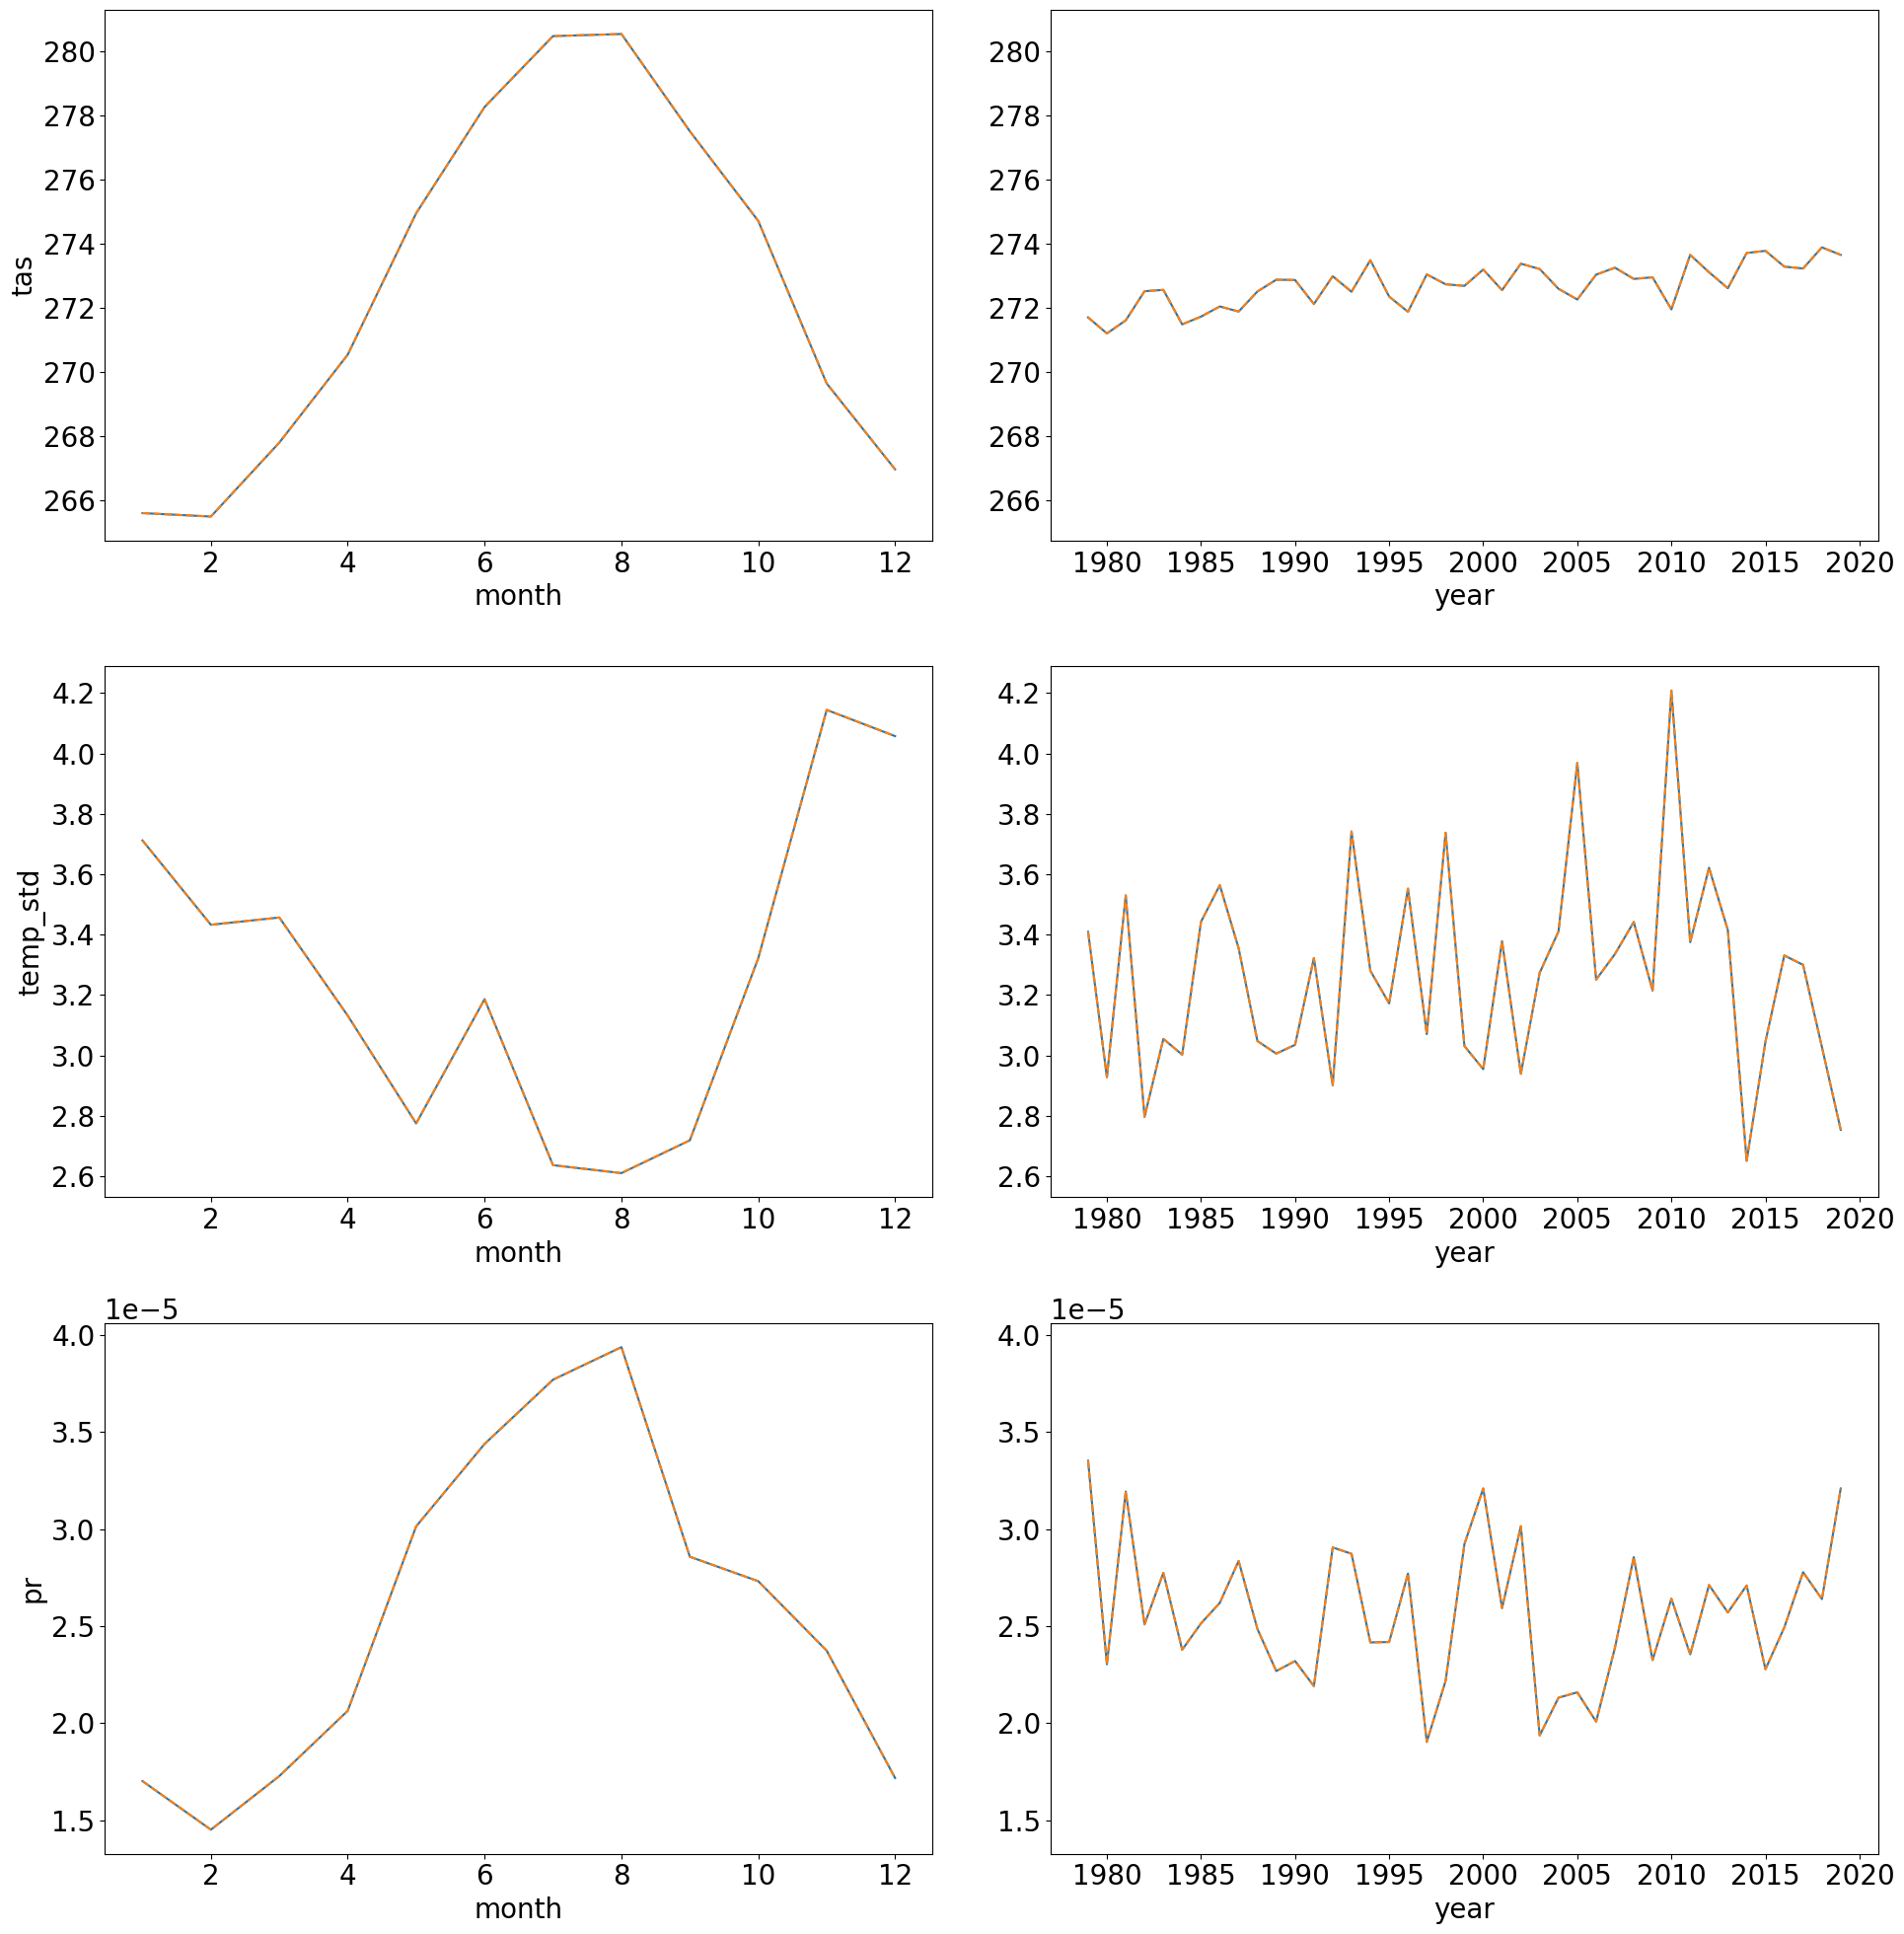

In [99]:
plt.rcParams['font.size'] = 20
j = 0
plt.figure(figsize=(20,20))
#plt.rcsize(20)
for var in ['tas', 'temp_std', 'pr']:
    if var == 'temp_std':
        var_w5e5 = 'tas_std'
    else:
        var_w5e5 = var
    for version in  ['2023.2']: #['2022_missing_points',
        
        if version == '2022_missing_points':
            path_w5e5 = f'/home/www/lschuster/w5e5v2.0/flattened/monthly/w5e5v2.0_{var_w5e5}_global_monthly_flat_glaciers_1979_2019.nc'
            pathi = f'/home/www/oggm/climate/gswp3-w5e5/flattened/monthly'

        else:
            path_w5e5 = f'/home/www/lschuster/w5e5v2.0/flattened/{version}/monthly/w5e5v2.0_{var_w5e5}_global_monthly_flat_glaciers_1979_2019.nc'
            pathi = f'/home/www/oggm/climate/gswp3-w5e5/flattened/{version}/monthly'

        ds_w5e5 = xr.open_dataset(path_w5e5)
    
        ds_gswp3_w5e5 = xr.open_dataset(pathi+'/gswp3-w5e5_obsclim_{}_global_monthly_1901_2019_flat_glaciers.nc'.format(var))
        # let's only look at the common time period!!!
        ds_gswp3_w5e5 = ds_gswp3_w5e5.sel(time=ds_w5e5.time)

        # this here is the main test, for all months and for all gridpoints, check if they coincide:
        # yes, they do!!!
        if var !='pr':
            np.testing.assert_allclose(ds_w5e5[var_w5e5], ds_gswp3_w5e5[var_w5e5], rtol=1e-6)
        else:
            # prcp is in daily mean values (kg m-2 s-1) and has much smaller values than temperatures, so datasets should be more similar
            np.testing.assert_allclose(ds_w5e5[var_w5e5], ds_gswp3_w5e5[var_w5e5], rtol=1e-9)


        # visual test just for HEF:
        lon, lat = (10.7584, 46.8003)
        c = (ds.longitude - lon)**2 + (ds.latitude - lat)**2
        plt.subplot(3,2,j+1)
        plt.plot(np.arange(1,13,1), ds_w5e5[var_w5e5].sel(points=c.argmin()).groupby('time.month').mean())
        plt.plot(np.arange(1,13,1), ds_gswp3_w5e5[var_w5e5].sel(points=c.argmin()).groupby('time.month').mean(),ls='--')
        j+=1
        plt.ylabel(var)
        ax=plt.gca()
        plt.xlabel('month')

        plt.subplot(3,2,j+1, sharey=ax)
        plt.plot(np.arange(1979,2020,1), ds_w5e5[var_w5e5].sel(points=c.argmin()).groupby('time.year').mean())
        plt.plot(np.arange(1979,2020,1), ds_gswp3_w5e5[var_w5e5].sel(points=c.argmin()).groupby('time.year').mean(), ls='--')
        j+=1
    plt.xlabel('year')
    
plt.tight_layout()

In [ ]:
# check for every glacier gridpoint if the correct climate dataset 
# was used by comparing it to the unflattened file:
# this takes some time (we only do this for the monthly files like that, it would take too long for the daily files)

# path_clim = '/home/www/oggm/climate/gswp3-w5e5/'
# don't run this ... 

run = False
if run:
    for version in ['2022_missing_points', '2023.2']:
        for var in ['pr', 'tas']:
            if version == '2022_missing_points':
                fp = f'/home/www/lschuster/w5e5v2.0/flattened/monthly/w5e5v2.0_{var}_global_monthly_flat_glaciers_1979_2019.nc'
            else:
                fp = f'/home/www/lschuster/w5e5v2.0/flattened/{version}/monthly/w5e5v2.0_{var}_global_monthly_flat_glaciers_1979_2019_.nc'
            ds_flattened = xr.open_dataset(fp)
            fp_unflat = f'/home/www/lschuster/w5e5v2.0/_script/{var}_W5E5v2.0_*.nc'
            with xr.open_mfdataset(fp_unflat) as ds_unflattened:
                ds_unflattened = ds_unflattened.resample(time='MS').mean()
            for p in ds_flattened.points[:100]:
                # get the point
                ds_flattened_sel = ds_flattened.sel(points=p)
                # select longitude, latitude and tas of that point
                lon_p = ds_flattened_sel.longitude.isel(time=0)
                lat_p = ds_flattened_sel.latitude.isel(time=0)
                var_p = ds_flattened_sel[var]
                # select the same gridpoint from the unflattened file
                # the unflattened file is in -180, 180
                if lon_p >=180:
                    lon_p = lon_p-360
                # check if the unflattened and the flattened file have the same climate
                # data inside
                np.testing.assert_allclose(var_p.values,
                                           ds_unflattened[var].sel(lon = lon_p, lat=lat_p))


## Create climate test files:
- this is for pytest in order that during the tests only a small part of the climate datasets are downloaded (just the nearest 4 points of HEF, of one glacier from RGI19 and two glaciers from only RGI7)!
- but these test files can not really be used to check if the right glacier gridpoints are selected, for that we use just the entire `inv` file which quite small (~100kb)

#### newer test files for 2025.11.25

In [47]:
# HEF location
lon, lat = (10.7584, 46.8003)
# RGI60-19.00124
lon2,lat2 = (-70.8931 +360, -72.4474)

lon3, lat3 = ( -141.670274+360, 69.166921) # in RGI7C, not in RGI6

lon4, lat4 = (-66.855668+360, -67.535551) # only in RGI7G, not in RGI6 or in RGI 7C

ERROR! Session/line number was not unique in database. History logging moved to new session 4277


- GSWP3-W5E5

In [3]:
test_clim_path = '/home/www/oggm/test_climate/gswp3-w5e5'
for version in ['2025.11.25']:
    v = f'_v{version}'
    for var in ['inv','tas', 'temp_std', 'pr']:
        if var == 'inv':
            ds = xr.open_dataset(f'/home/www/oggm/climate/gswp3-w5e5/flattened/{version}/monthly/gswp3-w5e5_glacier_invariant_flat{v}.nc')
            # we just take the entire invariant file inside because it does not make a big storage difference
            # same invariant file for both, monthly and daily
            ds.to_netcdf(f'{test_clim_path}/flattened/{version}/monthly/gswp3-w5e5_glacier_invariant_flat{v}.nc')
            ds.to_netcdf(f'{test_clim_path}/flattened/{version}/daily/gswp3-w5e5_glacier_invariant_flat{v}.nc')
        else:
            ds = xr.open_dataset(f'/home/www/oggm/climate/gswp3-w5e5/flattened/{version}/monthly/gswp3-w5e5_obsclim_{var}_global_monthly_1901_2019_flat_glaciers{v}.nc')
            if var != 'temp_std':
                ds_d = xr.open_dataset(f'/home/www/oggm/climate/gswp3-w5e5/flattened/{version}/daily/gswp3-w5e5_obsclim_{var}_global_daily_1901_2019_flat_glaciers{v}.nc')
        
            c = (ds.longitude - lon)**2 + (ds.latitude - lat)**2
            p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

            c2 = (ds.longitude - lon2)**2 + (ds.latitude - lat2)**2
            p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

            c3 = (ds.longitude - lon3)**2 + (ds.latitude - lat3)**2
            p3_nearest = c3.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 3

            c4 = (ds.longitude - lon4)**2 + (ds.latitude - lat4)**2
            p4_nearest = c4.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 4
            
            p_nearest = np.concatenate([p_nearest,p2_nearest, p3_nearest, p4_nearest])

            ds_test = ds.isel(points=p_nearest)
            ds_test.to_netcdf(f'{test_clim_path}/flattened/{version}/monthly/gswp3-w5e5_obsclim_{var}_global_monthly_1901_2019_flat_glaciers{v}.nc')

            if var != 'temp_std':
                ds_test_d = ds_d.isel(points=p_nearest)
                ds_test_d.to_netcdf(f'{test_clim_path}/flattened/{version}/daily/gswp3-w5e5_obsclim_{var}_global_daily_1901_2019_flat_glaciers{v}.nc')


- ISIMIP3b

In [48]:
test_clim_path = '/home/www/oggm/test_climate'
for version in ['2025.11.25']:
    v = f'_v{version}'
    for var in ['tasAdjust', 'prAdjust']:
        for ssp in ['ssp126', 'ssp585']:            
            ds = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_{ssp}_{var}_global_monthly_flat_glaciers{v}.nc')
            c = (ds.longitude - lon)**2 + (ds.latitude - lat)**2
            p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

            c2 = (ds.longitude - lon2)**2 + (ds.latitude - lat2)**2
            p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

            p_nearest = np.concatenate([p_nearest,p2_nearest])

            ds_test = ds.isel(points=p_nearest)
            ds_test.to_netcdf(f'{test_clim_path}/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_{ssp}_{var}_global_monthly_flat_glaciers{v}.nc')
            ds.close()

        ds_h = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_historical_{var}_global_monthly_flat_glaciers{v}.nc')
        
        c = (ds.longitude - lon)**2 + (ds.latitude - lat)**2
        p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

        c2 = (ds.longitude - lon2)**2 + (ds.latitude - lat2)**2
        p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

        c3 = (ds.longitude - lon3)**2 + (ds.latitude - lat3)**2
        p3_nearest = c3.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 3

        c4 = (ds.longitude - lon4)**2 + (ds.latitude - lat4)**2
        p4_nearest = c4.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 4
        
        p_nearest = np.concatenate([p_nearest,p2_nearest, p3_nearest, p4_nearest])

        ds_test = ds_h.isel(points=p_nearest)
        ds_test.to_netcdf(f'{test_clim_path}/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_historical_{var}_global_monthly_flat_glaciers{v}.nc')
        ds_h.close()



- ERA5

In [3]:
test_clim_path = '/home/www/oggm/test_climate/era5'
for version in ['2025.11.25']:
    v = f'_v{version}'
    for var in ['inv','t2m', 'tp']: #'temp_std', 
        if var == 'inv':
            ds = xr.open_dataset(f'/home/www/oggm/climate/era5/monthly/v1.2/flattened/era5_glacier_invariant_flat{v}.nc')
            #ds = ds.drop_vars('time')
            # we just take the entire invariant file inside because it does not make a big storage difference
            # same invariant file for both, monthly and daily
            ds.to_netcdf(f'{test_clim_path}/monthly/v1.2/flattened/era5_glacier_invariant_flat{v}.nc')
            ds.to_netcdf(f'{test_clim_path}/daily/v1.2/flattened/era5_glacier_invariant_flat{v}.nc')
        else:
            ds = xr.open_dataset(f'/home/www/oggm/climate/era5/monthly/v1.2/flattened/era5_{var}_global_monthly_1940_2024_flat_glaciers{v}.nc')
            if var != 'temp_std':
                ds_d = xr.open_dataset(f'/home/www/oggm/climate/era5/daily/v1.2/flattened/era5_{var}_global_daily_1940_2024_flat_glaciers{v}.nc')
        
            c = ((ds.longitude - lon)**2 + (ds.latitude - lat)**2)
            p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

            c2 = ((ds.longitude - lon2)**2 + (ds.latitude - lat2)**2)
            p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

            c3 = ((ds.longitude - lon3)**2 + (ds.latitude - lat3)**2)
            p3_nearest = c3.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 3

            c4 = ((ds.longitude - lon4)**2 + (ds.latitude - lat4)**2)
            p4_nearest = c4.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 4
            
            p_nearest_all = np.concatenate([p_nearest,p2_nearest, p3_nearest, p4_nearest])

            ds_test = ds.isel(points=p_nearest_all)
            ds_test.to_netcdf(f'{test_clim_path}/monthly/v1.2/flattened/era5_{var}_global_monthly_1940_2024_flat_glaciers{v}.nc')

            if var != 'temp_std':
                ds_test_d = ds_d.isel(points=p_nearest)
                ds_test_d.to_netcdf(f'{test_clim_path}/daily/v1.2/flattened/era5_{var}_global_daily_1940_2024_flat_glaciers{v}.nc')


#### old test files from 2022 and 2023.2

In [ ]:
# HEF location
lon, lat = (10.7584, 46.8003)
# RGI60-19.00124
lon2,lat2 = (-70.8931 +360, -72.4474)

#test_clim_path = '/home/www/lschuster/isimip3a/test_climate'
test_clim_path = '/home/www/oggm/test_climate/gswp3-w5e5'
for version in ['2022_missing_points', '2023.2']:
    for var in ['tas', 'temp_std', 'pr', 'inv']:
        if var == 'inv':
            ds = xr.open_dataset(f'/home/www/lschuster/isimip3a/flattened/{version}/gswp3-w5e5_glacier_invariant_flat.nc')
            # we just compy the entire invariant file inside because it does not make a big storage difference
            ds.to_netcdf(f'{test_clim_path}/flattened/{version}/monthly/gswp3-w5e5_glacier_invariant_flat.nc')
        else:
            ds = xr.open_dataset(f'/home/www/lschuster/isimip3a/flattened/{version}/monthly/gswp3-w5e5_obsclim_{var}_global_monthly_1901_2019_flat_glaciers.nc')
        
            c = (ds.longitude - lon)**2 + (ds.latitude - lat)**2
            p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

            c2 = (ds.longitude - lon2)**2 + (ds.latitude - lat2)**2
            p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

            p_nearest = np.concatenate([p_nearest,p2_nearest])

            ds_test = ds.isel(points=p_nearest)
   
            ds_test.to_netcdf(f'{test_clim_path}/flattened/{version}/monthly/gswp3-w5e5_obsclim_{var}_global_monthly_1901_2019_flat_glaciers.nc')

#www_lschuster/isimip3a/flattened/2022_missing_points/gswp3_w5e5_glacier_invariant_flat.nc

In [33]:
# HEF location
lon, lat = (10.7584, 46.8003)
# RGI60-19.00124
lon2,lat2 = (-70.8931 +360, -72.4474)

test_clim_path = '/home/www/oggm/test_climate'
for version in ['2022_missing_points', '2023.2']:
    for var in ['tasAdjust', 'prAdjust']:
        for ssp in ['ssp126', 'ssp585']:
            if version == '2022_missing_points':
                ds = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/monthly/mri-esm2-0_r1i1p1f1_w5e5_{ssp}_{var}_global_monthly_flat_glaciers.nc')
            else:
                ds = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_{ssp}_{var}_global_monthly_flat_glaciers.nc')
            c = (ds.longitude - lon)**2 + (ds.latitude - lat)**2
            p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

            c2 = (ds.longitude - lon2)**2 + (ds.latitude - lat2)**2
            p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

            p_nearest = np.concatenate([p_nearest,p2_nearest])

            ds_test = ds.isel(points=p_nearest)
            ds_test.to_netcdf(f'{test_clim_path}/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_{ssp}_{var}_global_monthly_flat_glaciers.nc')
            ds.close()
        if version == '2022_missing_points':
             ds_h = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/monthly/mri-esm2-0_r1i1p1f1_w5e5_historical_{var}_global_monthly_flat_glaciers.nc')
        else:
            ds_h = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_historical_{var}_global_monthly_flat_glaciers.nc')
        
        c = (ds_h.longitude - lon)**2 + (ds_h.latitude - lat)**2
        p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

        c2 = (ds_h.longitude - lon)**2 + (ds_h.latitude - lat)**2
        p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

        p_nearest = np.concatenate([p_nearest,p2_nearest])

        ds_test = ds_h.isel(points=p_nearest)
        ds_test.to_netcdf(f'{test_clim_path}/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_historical_{var}_global_monthly_flat_glaciers.nc')
        ds_h.close()



### Check of Sarah's downscaled flattened data:

In [14]:
sarah_files_l = []

folder_p = '/home/www/shanus/ISIMIP3a/flattened/daily/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        sarah_files_l.append(folder_p+p)

folder_p = '/home/www/shanus/ISIMIP3b/flattened/daily/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        sarah_files_l.append(folder_p+p)
        
def test_glacier_gridpoint_selection_sarah(p, short = True, print_stuff=False, max_dist=0.0417):
    # file path (ISIMIP3a or ISIMIP3b)
    if 'inv' not in p:
        with xr.open_dataset(p) as dt:
            dt = dt.isel(time=0) # we only need the lat/lon anyways
    else:
        dt = xr.open_dataset(p)
    if short:
        # select three glaciers where two failed in the
        # previous gswp3_w5e5 version
        coords = [(10.7584, 46.8003),  # HEF
                      (-70.8931, -72.4474),  # RGI60-19.00124
                      (51.495, 30.9010),  # RGI60-12.01691
                      ]
    else:
        coords = odf['coords']
    for coord in coords:
        lon, lat = coord
        if lon <0:
            lon = lon + 360
        # get the distances to the glacier coordinate
        c = ((dt.longitude - lon) ** 2 + (dt.latitude - lat) ** 2)**0.5
        # select the nearest climate point from the flattened
        # glacier gridpoint
        if 'inv' in p:
            lat_near, lon_near, dist = c.to_dataframe('distance').sort_values('distance').iloc[0]
            # for a randomly chosen gridpoint, the next climate gridpoint is far away
            # for glacier gridpoints the next gridpoint should be the nearest
            # (GSWP3-W5E5 resolution is 0.5°)
            if print_stuff:
                print(p, dist, lat_near, lat, lon_near, lon)
                print(lat_near-lat)
            assert dist <= (max_dist ** 2 + max_dist ** 2) ** 0.5
            assert np.abs(lat_near - lat) <= max_dist
            assert np.abs(lon_near - lon) <= max_dist
        else:
            dist = c.to_dataframe('distance').sort_values('distance').distance.iloc[0]
            if print_stuff:
                print(p, dist, lon, lat)
            assert dist <= (max_dist ** 2 + max_dist ** 2) ** 0.5
for p in sarah_files_l:
    print(p)
    test_glacier_gridpoint_selection_sarah(p,short=False,print_stuff=False)

ok, it looks good in case of sarah's files: (I just checked the first ISIMIP3a /3b files but that should be sufficient:

In [ ]:
for p in sarah_files_l:
    print(p)
    test_glacier_gridpoint_selection_sarah(p,short=False,print_stuff=False)

/home/www/shanus/ISIMIP3a/flattened/daily/gswp3-w5e5_obsclim_glacier_invariant_flat.nc
/home/www/shanus/ISIMIP3a/flattened/daily/gswp3-w5e5_obsclim_tas_global_daily_flat_glaciers_1979_2019.nc
/home/www/shanus/ISIMIP3a/flattened/daily/gswp3-w5e5_obsclim_pr_global_daily_flat_glaciers_1979_2019.nc
/home/www/shanus/ISIMIP3b/flattened/daily/ipsl-cm6a-lr_r1i1p1f1_w5e5_ssp370_prAdjust_global_daily_flat_glaciers_2015_2100.nc
/home/www/shanus/ISIMIP3b/flattened/daily/ipsl-cm6a-lr_r1i1p1f1_w5e5_ssp585_prAdjust_global_daily_flat_glaciers_2015_2100.nc
/home/www/shanus/ISIMIP3b/flattened/daily/mri-esm2-0_r1i1p1f1_w5e5_ssp126_tasAdjust_global_daily_flat_glaciers_2015_2100.nc
/home/www/shanus/ISIMIP3b/flattened/daily/mri-esm2-0_r1i1p1f1_w5e5_ssp370_tasAdjust_global_daily_flat_glaciers_2015_2100.nc
